#Cointegration analysis and pairs trading strategy using Z-score.

###1. Data Loading and Preprocessing:
- The code loads data for various tickers (cryptocurrencies, bank stocks, and global indexes) from a specified date range.
- It preprocesses the data by handling missing values, interpolating, and filling NaN values.

###2. Cointegration Analysis:
- The find_cointegrated_pairs function calculates the cointegration p-values between pairs of tickers using the Augmented Dickey-Fuller (ADF) test.
- It plots a heatmap to visualize the cointegration p-values.
The function returns a list of cointegrated pairs based on a specified p-value threshold.

###3. Plotting Cointegrated Pairs:
- The code sorts the cointegrated pairs based on their p-values and selects the top 35 pairs.
- It plots a horizontal bar chart to visualize the p-values of the selected pairs.
- Visualization of Cointegrated Pairs:
    - The code selects a few cointegrated pairs (e.g., 'BTC-USD' and 'XCN-USD', 'BTC-USD' and 'BTCB-USD', 'AAVE-USD' and 'BSV-USD').
    - It plots the scaled time series data for each pair along with their rolling means (Simple Moving Average, SMA).

###4. Z-Score Analysis and Trading Strategy:
- The signals_zscore_evolution function calculates the z-scores of the ratio between two time series (e.g., 'AAVE-USD' and 'BSV-USD').
- It generates buy and sell signals based on the z-score crossing a specified threshold.
- The function returns a DataFrame with 'signal' and 'orders' columns containing the trading signals.

###5. Profit Calculation and Visualization:
- The calculate_profit function calculates the profit based on the trading signals and price series.
- The plot_strategy function visualizes the trading strategy by plotting the price series, buy/sell signals, and cumulative profit.
- The code calculates and plots the trading strategy and profit for the 'AAVE-USD' and 'BSV-USD' pair, considering both tickers as the primary signal source.
- It also plots the combined cumulative profit for both trading strategies.

In [1]:
!pip install numpy
!pip install pandas
!pip install yfinance as yf

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

def load_ticker_ts_df(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

In [3]:
import pandas as pd
import numpy as np

crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB', 'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100', '^RUT', '^VIX', '^TNX']

START_DATE = '2021-01-01'
END_DATE = '2024-04-15'

universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes
universe_tickers_ts_map = {ticker: load_ticker_ts_df(ticker, START_DATE, END_DATE) for ticker in universe_tickers}

def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)).days
    data_sanitized = {}
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')

    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            continue
        if len(data) > TS_DAYS_LENGTH:
            data = data[-TS_DAYS_LENGTH:]

        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)

        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(np.isinf(data['Adj Close']))
        data_sanitized[ticker] = data

    return data_sanitized

uts_sanitized = sanitize_data(universe_tickers_ts_map)
print(uts_sanitized['JPM'].shape, uts_sanitized['BTC-USD'].shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(1201, 6) (1201, 6)


In [4]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)
    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))
    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]
    return pvalue_matrix, pairs

# This section can take up to 5mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

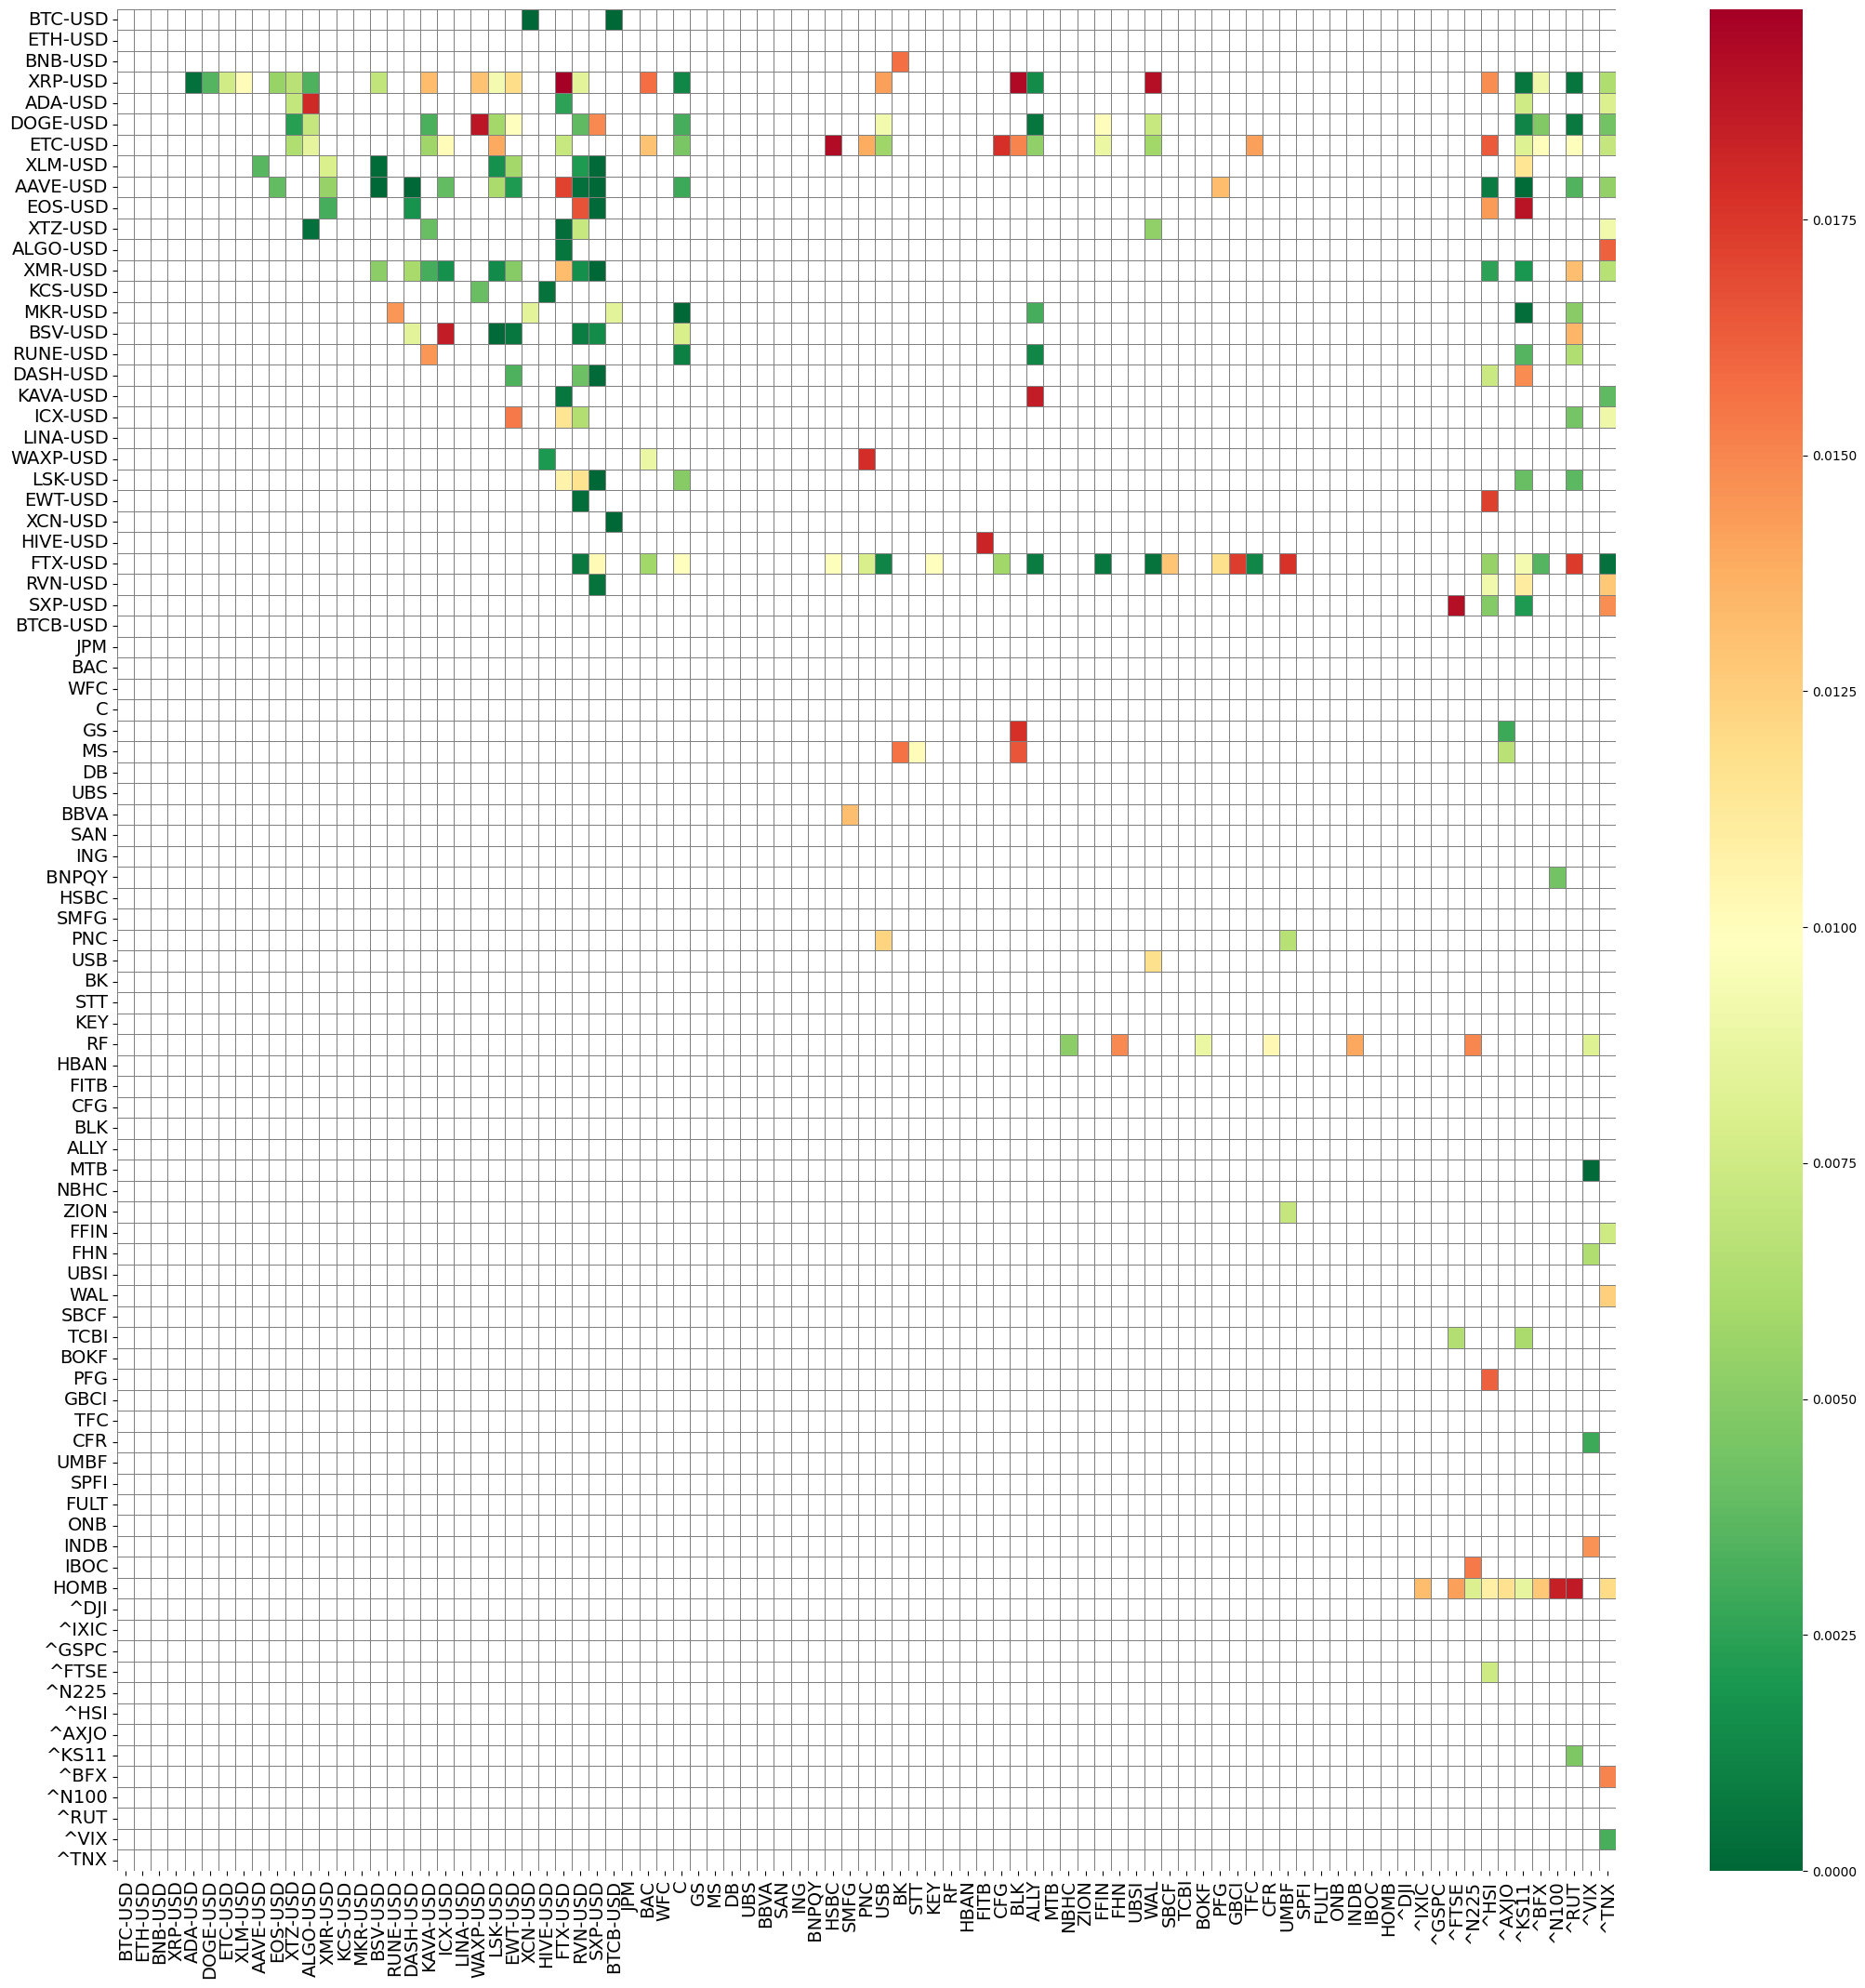

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

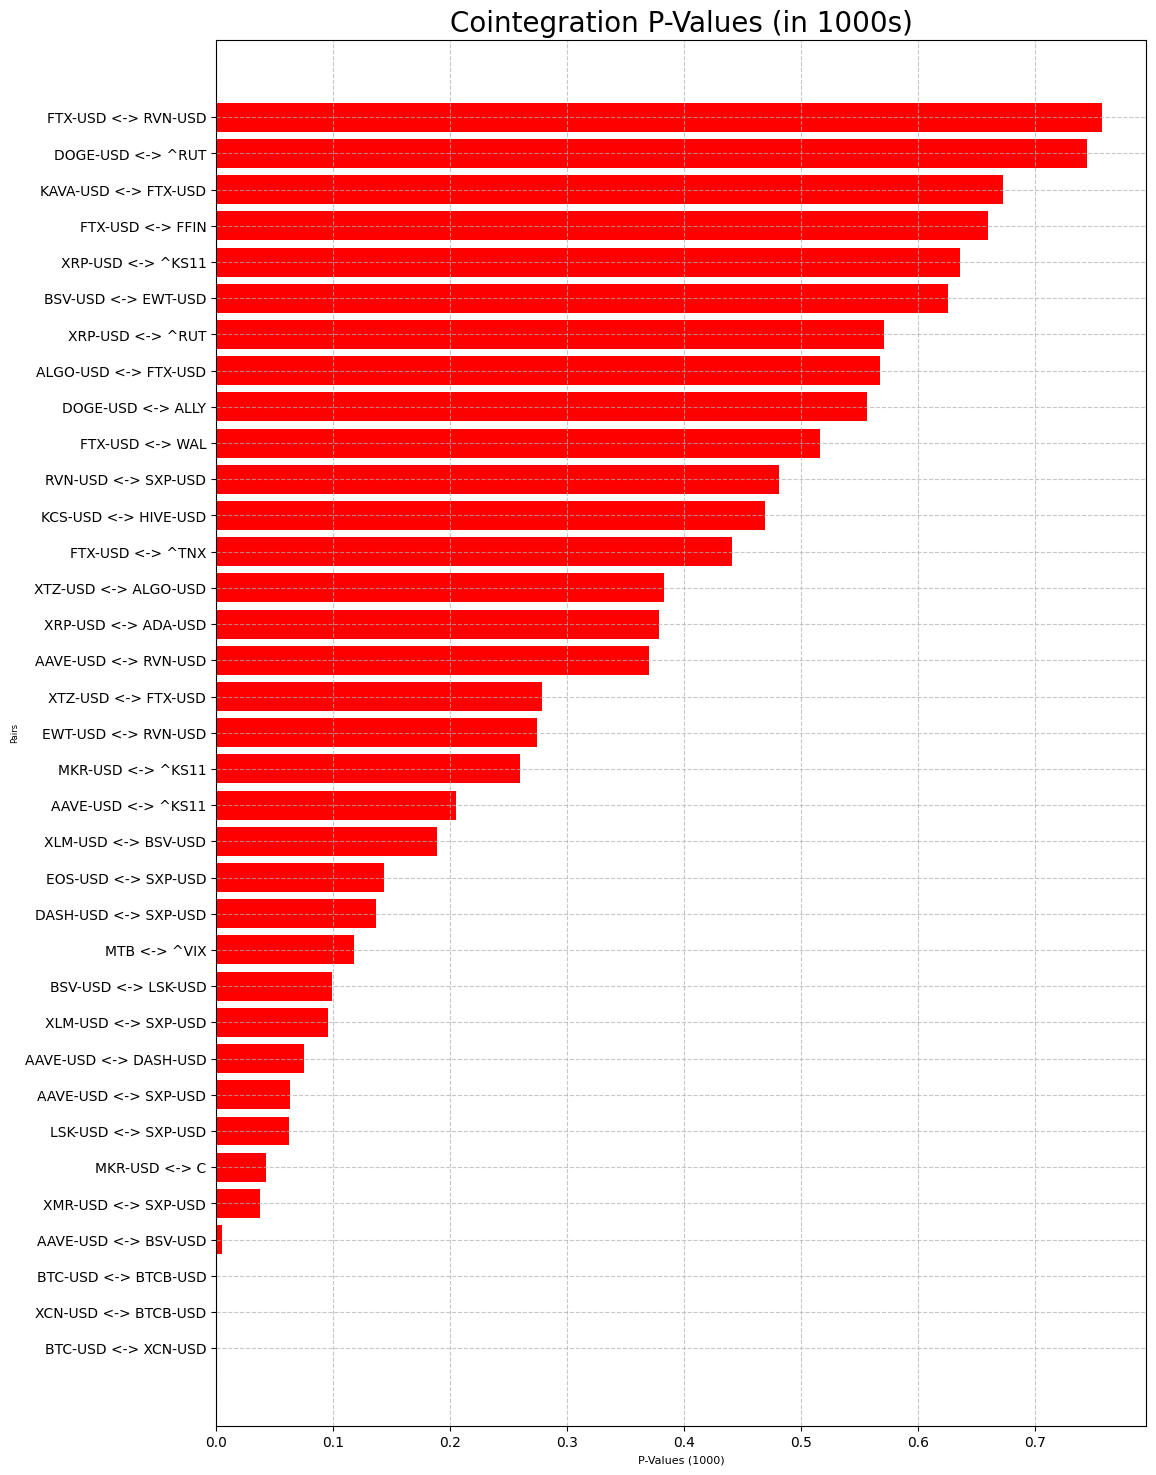

In [6]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])
plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

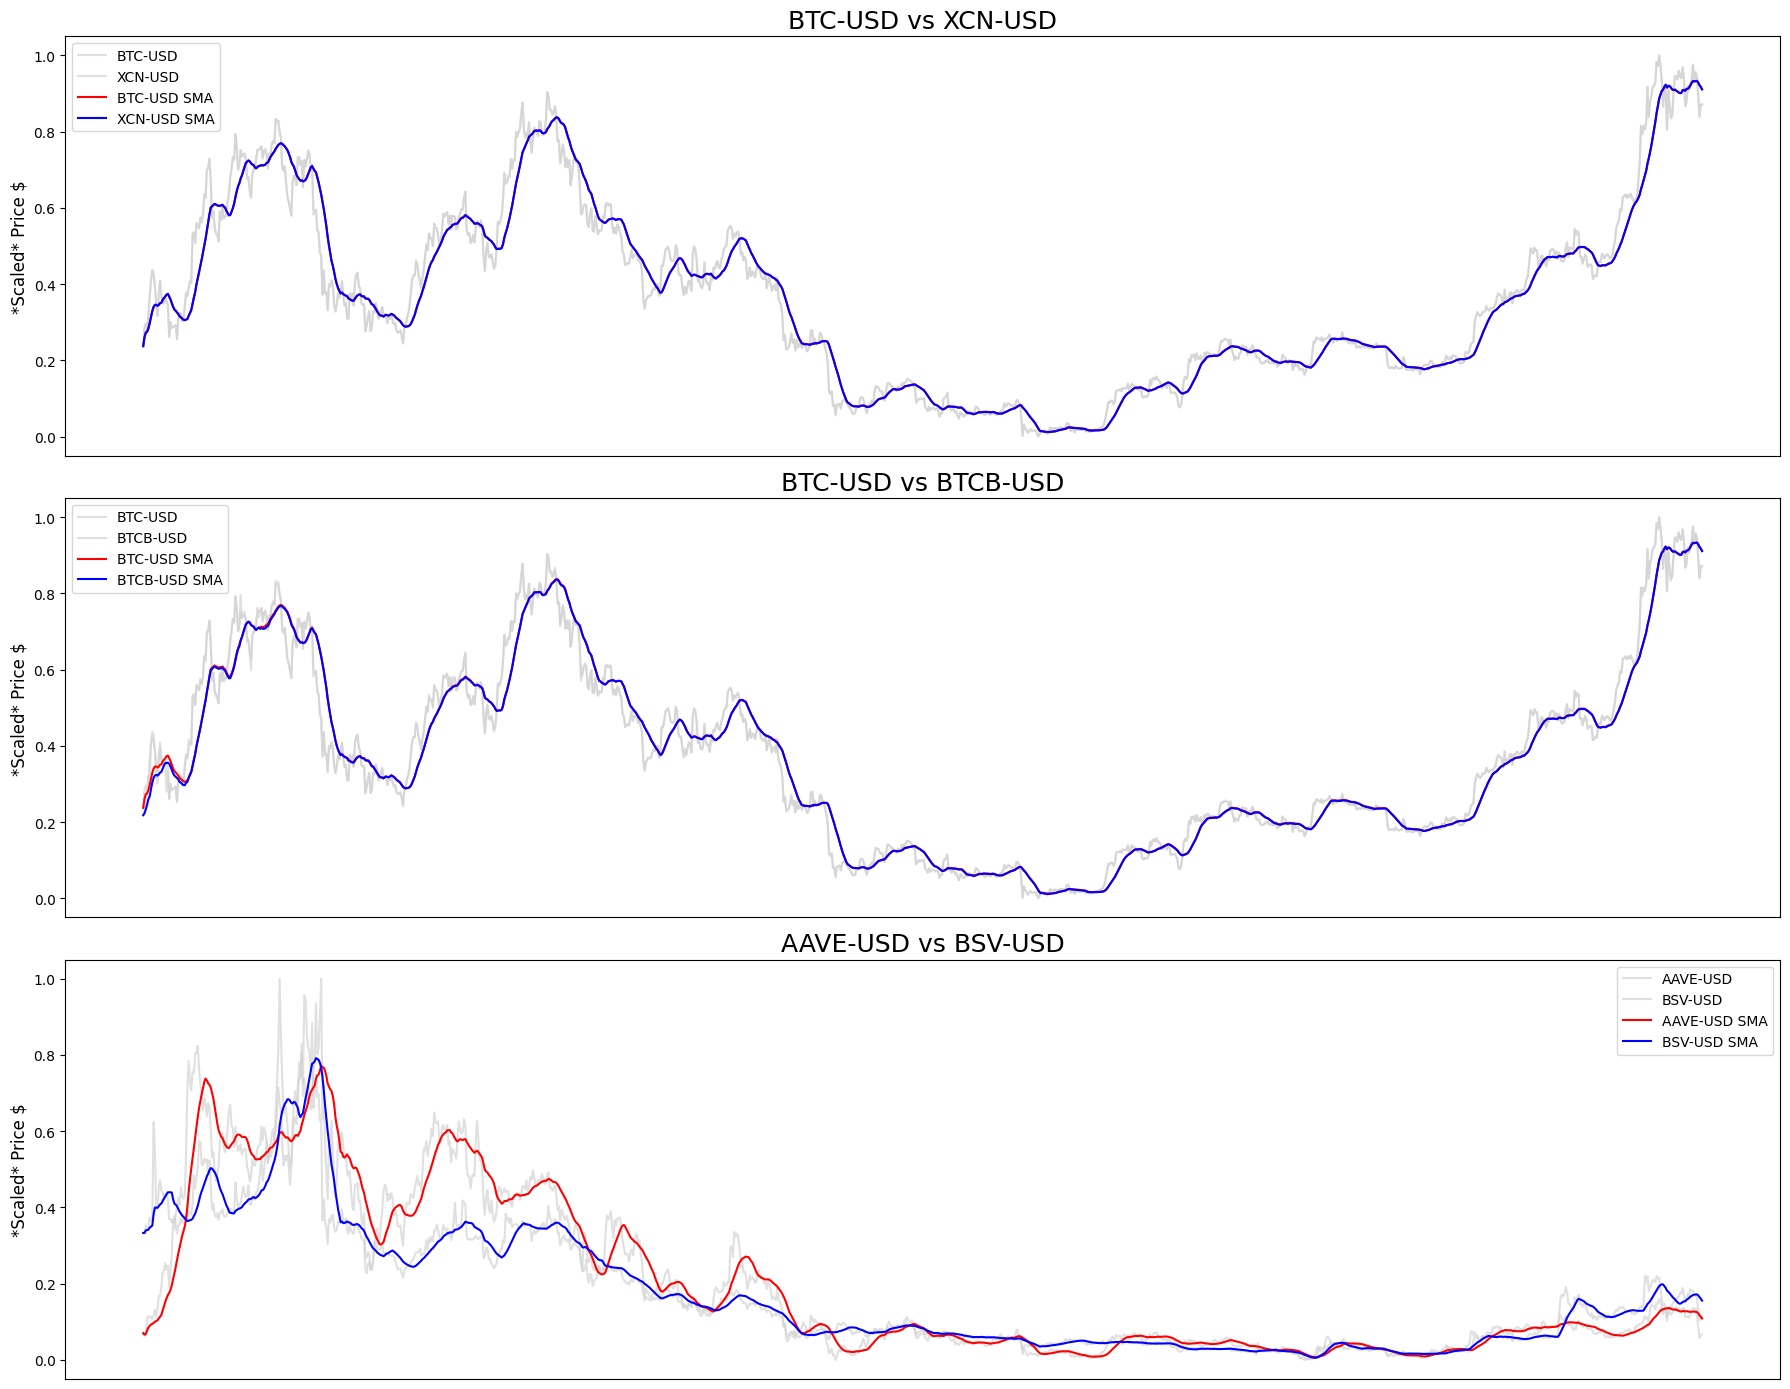

In [7]:
from sklearn.preprocessing import MinMaxScaler

ticker_pairs = [("BTC-USD", "XCN-USD"), ("BTC-USD", "BTCB-USD"), ("AAVE-USD", "BSV-USD")]
fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()
for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_sanitized[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_sanitized[ticker2]['Adj Close'].values.reshape(-1, 1))
    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)
    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()
    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')
    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])
plt.tight_layout()
plt.show()


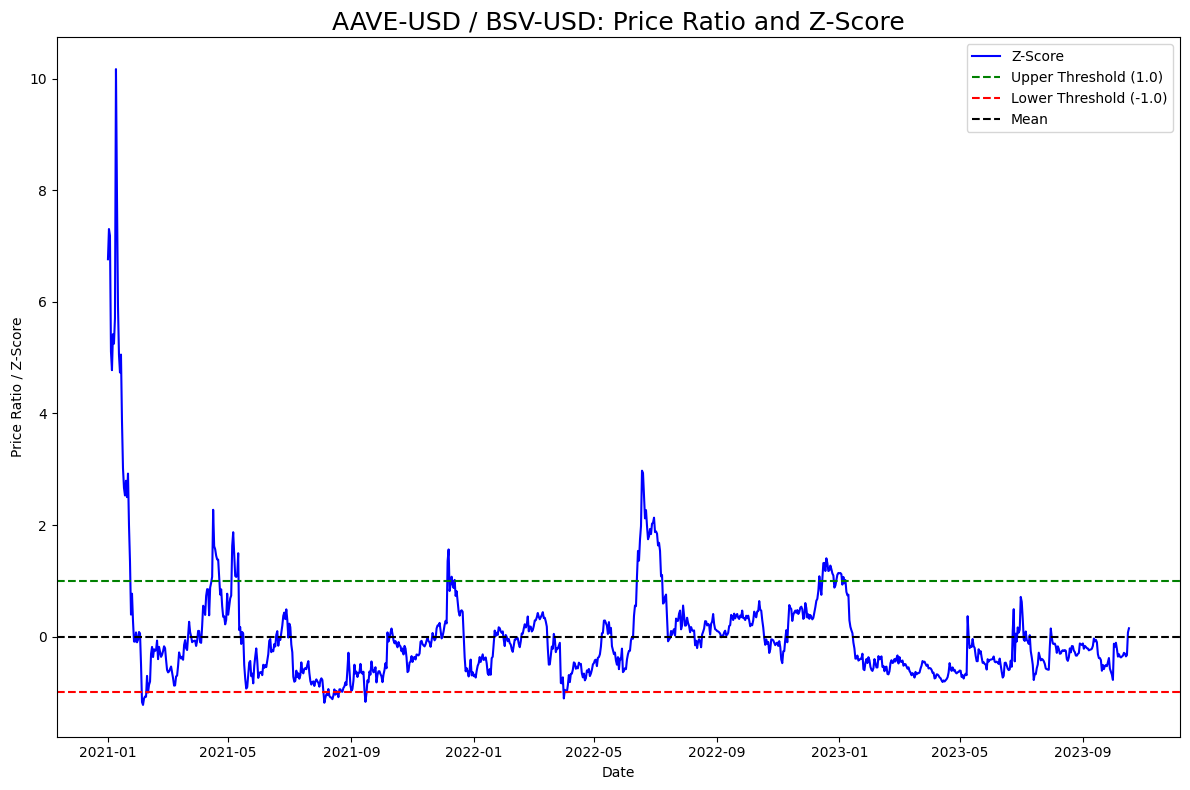

In [8]:
TRAIN = int(len(uts_sanitized["AAVE-USD"]) * 0.85)
TEST = len(uts_sanitized["AAVE-USD"]) - TRAIN

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["BSV-USD"]["Adj Close"][:TRAIN]
# Calculate price ratio (AAVE-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))
ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std
ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')
# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Mean")
ax.set_title('AAVE-USD / BSV-USD: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
def calculate_profit(signals_df, price_series):
    """
    Calculate the profit based on the trading signals and price series.

    Parameters:
    - signals_df (pandas.DataFrame): DataFrame containing the trading signals ('signal' and 'orders' columns).
    - price_series (pandas.Series): Time series of prices.

    Returns:
    - profit_df (pandas.DataFrame): DataFrame containing the profit for each trade.
    """
    # Create a DataFrame to store the profit for each trade
    profit_df = pd.DataFrame(index=price_series.index)
    profit_df['profit'] = 0.0

    # Iterate over the signals and calculate the profit
    for i in range(1, len(signals_df)):
        signal = signals_df['signal'].iloc[i]
        if signal != 0:
            if signal == 1:
                # Buy signal
                profit_df.loc[signals_df.index[i], 'profit'] = price_series.pct_change().iloc[i]
            else:
                # Sell signal
                profit_df.loc[signals_df.index[i], 'profit'] = -price_series.pct_change().iloc[i]

    # Calculate the cumulative profit
    profit_df['profit'] = profit_df['profit'].cumsum()

    return profit_df

In [10]:
def plot_strategy(price_series, signals_df, profit_df):
    """
    Plot the trading strategy and profit.

    Parameters:
    - price_series (pandas.Series): Time series of prices.
    - signals_df (pandas.DataFrame): DataFrame containing the trading signals ('signal' and 'orders' columns).
    - profit_df (pandas.DataFrame): DataFrame containing the profit for each trade.

    Returns:
    - ax1 (matplotlib.axes._subplots.AxesSubplot): Axis object for price and signal plot.
    - ax2 (matplotlib.axes._subplots.AxesSubplot): Axis object for profit plot.
    """
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot price and signals
    ax1.plot(price_series, label='Price')
    ax1.scatter(signals_df.loc[signals_df['signal'] == 1].index, price_series[signals_df['signal'] == 1], marker='^', color='g', label='Buy')
    ax1.scatter(signals_df.loc[signals_df['signal'] == -1].index, price_series[signals_df['signal'] == -1], marker='v', color='r', label='Sell')
    ax1.set_title('Trading Strategy')
    ax1.legend(loc='upper left')

    # Plot profit
    profit_df['profit'].plot(ax=ax2)
    ax2.set_title('Profit')

    plt.tight_layout()

    return ax1, ax2

In [12]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True, threshold=1):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.

    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.
    - threshold (float): The z-score threshold for generating buy and sell signals.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = 0.0

    if first_ticker:
        signals_df.loc[z_scores > threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores < -threshold, 'signal'] = -1  # Sell signal
    else:
        signals_df.loc[z_scores < -threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores > threshold, 'signal'] = -1  # Sell signal

    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

<Figure size 2600x1800 with 0 Axes>

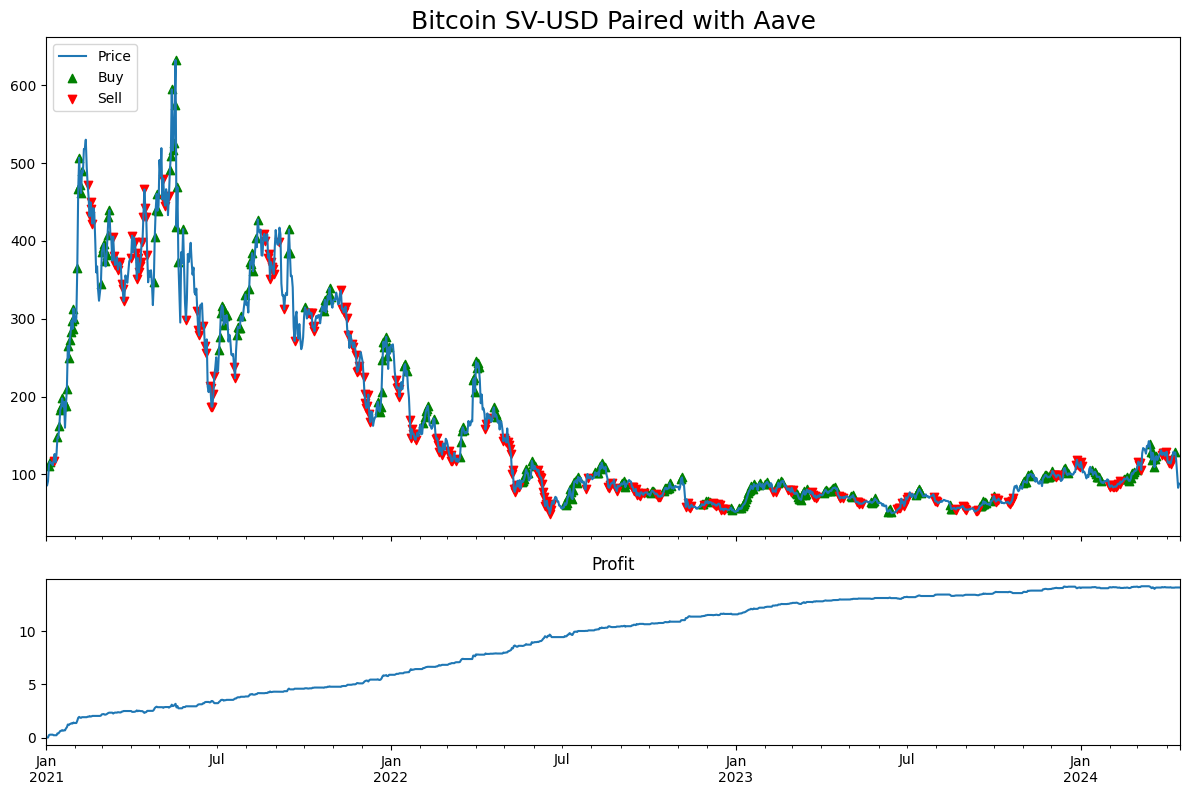

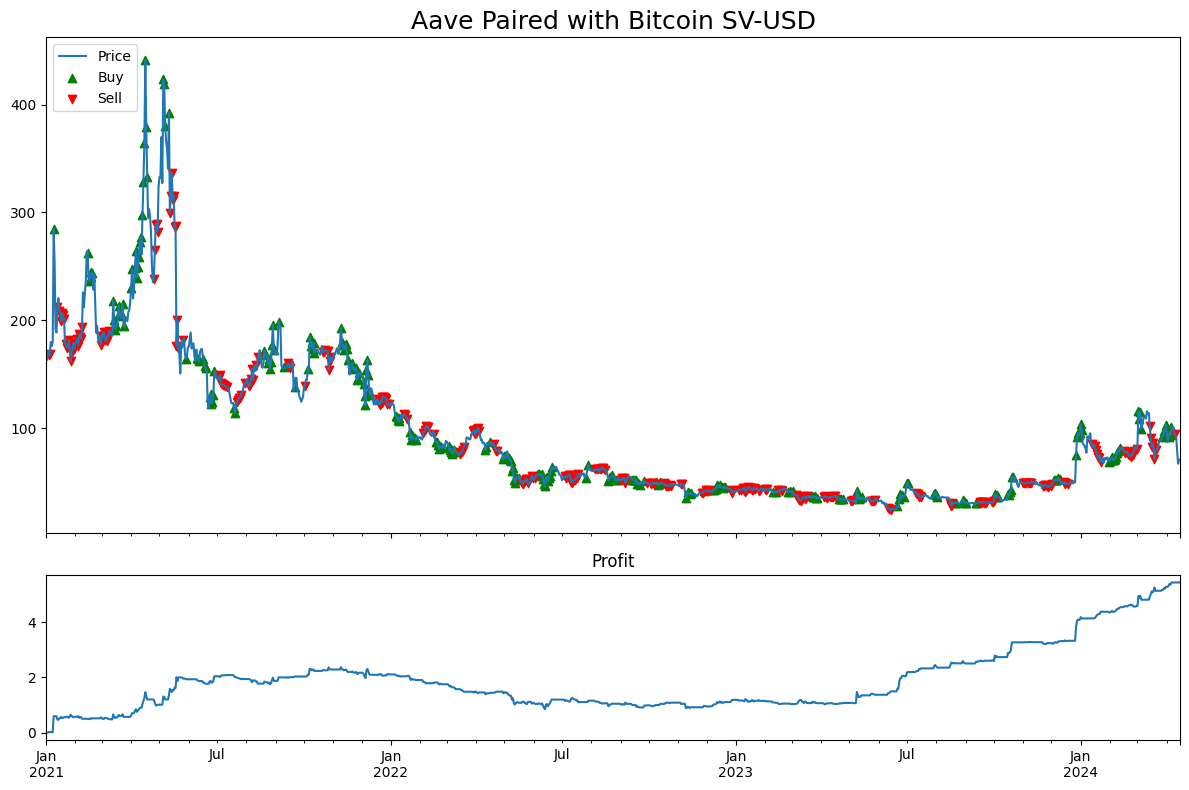

In [13]:
AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"]
C_ts = uts_sanitized["BSV-USD"]["Adj Close"]

plt.figure(figsize=(26, 18))

signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts, threshold=1)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)

signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False, threshold=1)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)

ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'Bitcoin SV-USD Paired with Aave', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'Aave Paired with Bitcoin SV-USD', fontsize=18)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

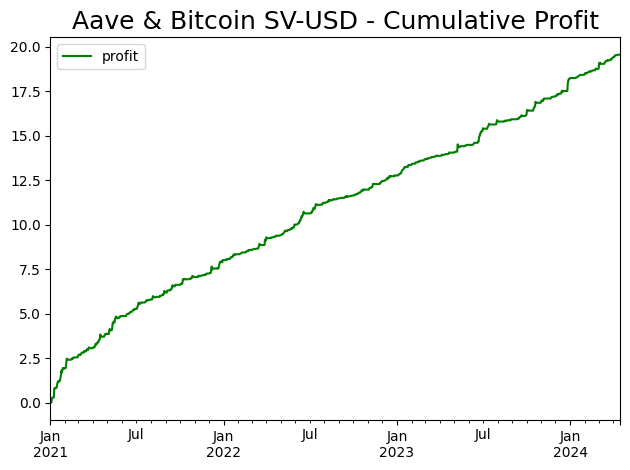

In [14]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'Aave & Bitcoin SV-USD - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 2600x1800 with 0 Axes>

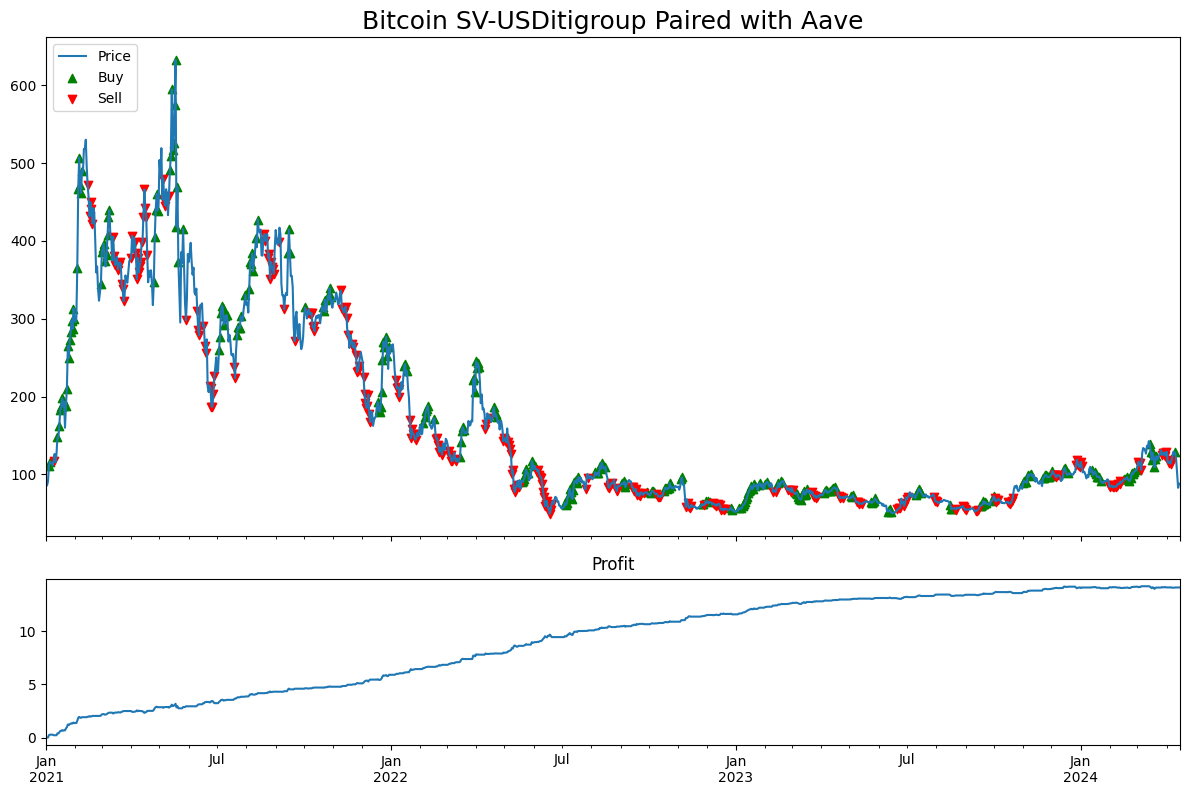

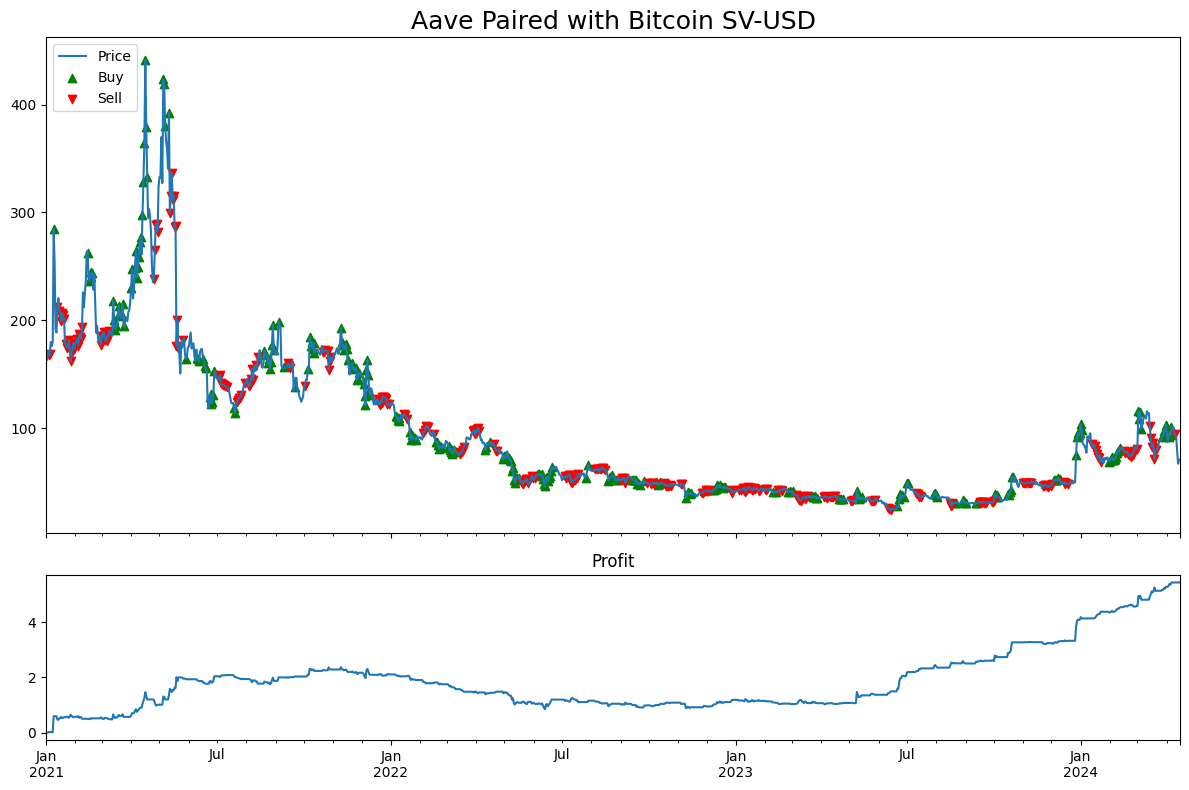

In [15]:
def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True, threshold=1):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.

    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.
    - threshold (float): The z-score threshold for generating buy and sell signals.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = 0.0

    if first_ticker:
        signals_df.loc[z_scores > threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores < -threshold, 'signal'] = -1  # Sell signal
    else:
        signals_df.loc[z_scores < -threshold, 'signal'] = 1  # Buy signal
        signals_df.loc[z_scores > threshold, 'signal'] = -1  # Sell signal

    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"]
C_ts = uts_sanitized["BSV-USD"]["Adj Close"]
plt.figure(figsize=(26, 18))
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)
signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)
ax2, _ = plot_strategy(C_ts, signals_df2, profit_df2)
ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f'Bitcoin SV-USDitigroup Paired with Aave', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f'Aave Paired with Bitcoin SV-USD', fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

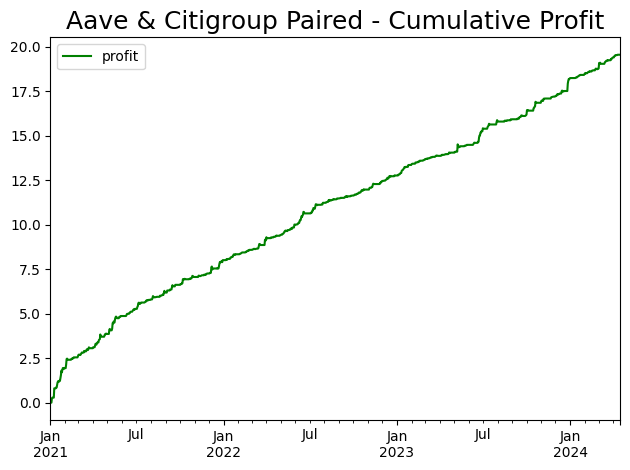

In [16]:
plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'Aave & Citigroup Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()